In [18]:
import sys, importlib, os, json, h3, uuid, datetime
from types import SimpleNamespace
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import datautils as du
importlib.reload(du)

args = SimpleNamespace()

args.latlon = [34.0522, -118.2437]
args.h3id9 = h3.latlng_to_cell(*args.latlon, res=9)
args.h3id5 = h3.latlng_to_cell(*args.latlon, res=5)[:8]
args.h3id1 = h3.latlng_to_cell(*args.latlon, res=1)[:5]
args.uuid = str(uuid.uuid1())[:18]
args.uuid8 = args.uuid[:8]
args.date = datetime.datetime.now().strftime("%Y%m%d")
args.pid = f'{args.h3id9}-{args.date}-{args.uuid8}'
args.data = SimpleNamespace()
args.data.gcp_root = f'{args.h3id1}/{args.h3id5}/{args.pid}'

du.fetch_meteo(args)

#np.savez('/Users/gamayos/Downloads/test.npz', **args.daily_data, allow_pickle=True)

#with open('/Users/gamayos/Downloads/meteo.json', 'w') as f:
#        json.dump(args.daily_data, f, default=str)

#du.gcp_upload_file(args, '/Users/gamayos/Downloads/meteo.json', f'{args.data.gcp_root}/{args.pid}-meteo.json')
#read data from npz file

#data = np.load('/Users/gamayos/Downloads/test.npz')

#print(data) #['date'].shape)

Coordinates 34.05975341796875°N -118.23750305175781°E
Elevation 91.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


In [12]:
import aiohttp, asyncio
from types import SimpleNamespace
import nest_asyncio

nest_asyncio.apply()

async def fetch_data(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            if response.status == 200:
                data = await response.json()
                print(f"Received data: {data}")
            else:
                print(f"Failed to fetch data. Status code: {response.status}")

async def makeNFT(args):
    url = "https://us-central1-ecomandala.cloudfunctions.net/makeNFT"
    # Schedule the API call and continue with other tasks
    asyncio.create_task(fetch_data(f'{url}/{args.uuid}'))

args = SimpleNamespace()
args.uuid = 'c44a199c-b972-11ef'

# Run the asyncio event loop
asyncio.run(makeNFT(args))



In [16]:
!pip install google-cloud-pubsub

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.1 MB/s eta 0:00:00 0:00:01


In [28]:
event = {'attributes': {'specversion': '1.0', 'id': '13210844352140311', 'source': '//pubsub.googleapis.com/projects/ecomandala/topics/make-nft', 'type': 'google.cloud.pubsub.topic.v1.messagePublished', 'datacontenttype': 'application/json', 'time': '2024-12-14T13:41:31.481Z'}, 'data': {'message': {'data': 'ODkxZTg4NzkzMjdmZmZm', 'messageId': '13210844352140311', 'message_id': '13210844352140311', 'publishTime': '2024-12-14T13:41:31.481Z', 'publish_time': '2024-12-14T13:41:31.481Z'}, 'subscription': 'projects/ecomandala/subscriptions/eventarc-us-central1-make-nft-test-2-368675-sub-919'}}

import base64

message = base64.b64decode(event['data']['message']['data']).decode('utf-8')
print(f"Received message: {message}")

Received message: 891e8879327ffff


In [ ]:
git stash applyimport pandas as pd

daily = args.meteo_response.Daily()

# leave out the time, leave only the date in the code below
daily_data = {"date": pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True).normalize().strftime('%Y-%m-%d'),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True).normalize().strftime('%Y-%m-%d'),
    freq=pd.Timedelta(days=1),
    inclusive="left"
)}
daily_data['juldate'] = daily_data['date'].to_julian_date().astype(int)

print(daily_data['juldate'][:10])

Index([2460269, 2460270, 2460271, 2460272, 2460273, 2460274, 2460275, 2460276,
       2460277, 2460278],
      dtype='int64')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08227959623910344..1.0979659121395602].


(55, 360, 4)
(35, 360, 4)
(360, 519, 3)


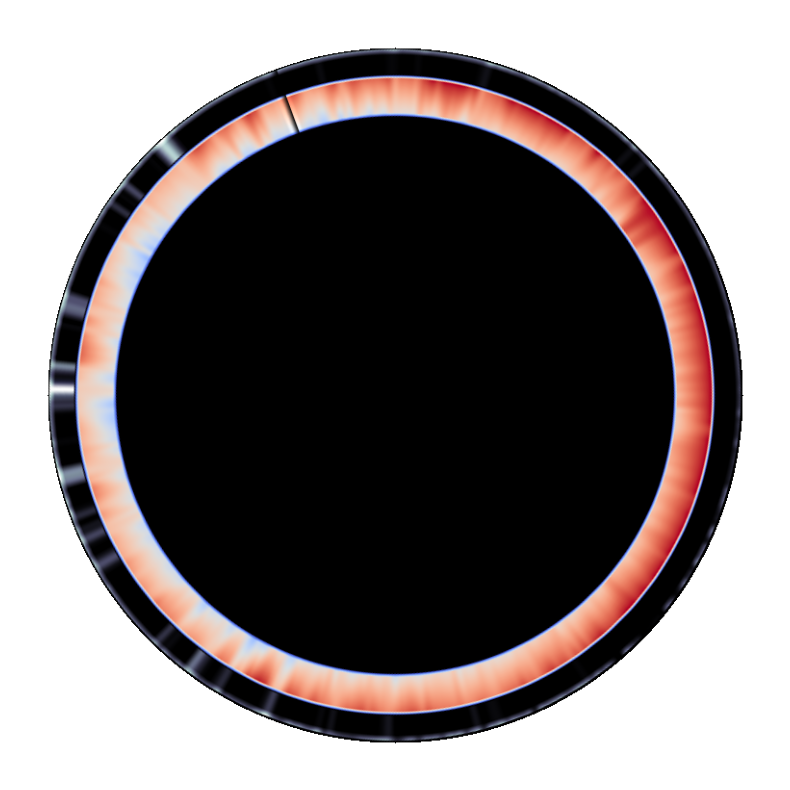

In [33]:
import numpy as np
from skimage import transform

import datautils as du
importlib.reload(du)

ttmat = du.render_temperature(args)
print(ttmat.shape)

ptmat = du.render_precipitation(args)
print(ptmat.shape)

buff = np.array([0,0,0,1])[None,None,:] * np.ones((4,360))[:,:,None]
buff0 = np.array([0,0,0,1])[None,None,:] * np.ones((48,360))[:,:,None]
buff1 = np.array([0,0,0,1])[None,None,:] * np.ones((377,360))[:,:,None]

mmmat = np.r_[buff0,buff,ptmat,ttmat,buff1].transpose((1,0,2))[::-1,::-1,:3]
print(mmmat.shape)

mandala1 = du.topolar(mmmat)
mandala1 = transform.rotate(mandala1, 200)

# Create a mask for the circle
h, w = mandala1.shape[:2]
center = (h // 2, w // 2)
radius = 361
Y, X = np.ogrid[:h, :w]
dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
mask = dist_from_center <= radius

# Apply the mask to the alpha channel
alpha_channel = np.ones_like(mandala1[..., 0])
alpha_channel[~mask] = 0
mandala1 = np.dstack((mandala1, alpha_channel))

fig = plt.figure(figsize=(10,10))
plt.imshow(mandala1)
plt.axis('off')
fig.savefig('/Users/gamayos/Downloads/test.png', format='png', dpi=100, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [83]:
from icecream import ic
import json, requests

uri = 'https://storage.googleapis.com/0x7ee601307fa4/s2dr3-202312-5242f0460600.json'
uri = 'https://us-central1-ecomandala.cloudfunctions.net/ecomandala/generate/j111222kdfshf'
uri = 'https://us-central1-ecomandala.cloudfunctions.net/ecomandala/list'
uri = 'https://us-central1-ecomandala.cloudfunctions.net/ecomandala/meteo/8929a1d7577ffff-20241126-0ea1f504'
#uri = 'https://storage.googleapis.com/ecomandala-preprod-9f3489c8-eb24-4d88/8129b/8529a1d7/8929a1d7577ffff-20241126-0ea1f504/8929a1d7577ffff-20241126-0ea1f504-meteo.json'
#url = 'https://storage.googleapis.com/ecomandala-preprod-9f3489c8-eb24-4d88/8129b/8529a1d7/8929a1d7577ffff-20241126-0ea1f504/8929a1d7577ffff-20241126-0ea1f504-meteo.json'
response = json.loads(requests.get(uri).text)
ic(response)

ic| response: {'date': "DatetimeIndex(['2023-11-21 23:00:00+00:00', '2023-11-22 "
                       "23:00:00+00:00',
              "
                       "               '2023-11-23 23:00:00+00:00', '2023-11-24 "
                       "23:00:00+00:00',
              "
                       "               '2023-11-25 23:00:00+00:00', '2023-11-26 "
                       "23:00:00+00:00',
              "
                       "               '2023-11-27 23:00:00+00:00', '2023-11-28 "
                       "23:00:00+00:00',
              "
                       "               '2023-11-29 23:00:00+00:00', '2023-11-30 "
                       "23:00:00+00:00',
              "
                       '               ...
              '
                       "               '2024-11-12 23:00:00+00:00', '2024-11-13 "
                       "23:00:00+00:00',
              "
                       "               '2024-11-14 23:00:00+00:00', '2024-11-15 "
                       "2

{'date': "DatetimeIndex(['2023-11-21 23:00:00+00:00', '2023-11-22 23:00:00+00:00',\n               '2023-11-23 23:00:00+00:00', '2023-11-24 23:00:00+00:00',\n               '2023-11-25 23:00:00+00:00', '2023-11-26 23:00:00+00:00',\n               '2023-11-27 23:00:00+00:00', '2023-11-28 23:00:00+00:00',\n               '2023-11-29 23:00:00+00:00', '2023-11-30 23:00:00+00:00',\n               ...\n               '2024-11-12 23:00:00+00:00', '2024-11-13 23:00:00+00:00',\n               '2024-11-14 23:00:00+00:00', '2024-11-15 23:00:00+00:00',\n               '2024-11-16 23:00:00+00:00', '2024-11-17 23:00:00+00:00',\n               '2024-11-18 23:00:00+00:00', '2024-11-19 23:00:00+00:00',\n               '2024-11-20 23:00:00+00:00', '2024-11-21 23:00:00+00:00'],\n              dtype='datetime64[ns, UTC]', length=367, freq='D')",
 'precipitation_sum': '[0.0000000e+00 0.0000000e+00 1.0000000e-01 1.0000000e-01 0.0000000e+00\n 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e-01 0.0000000e